* Выполняемое задание -- Задача 5. Обучение без учителя
* Студент: Шеверев Сергей Вячеславович, 22М-05ММ
* Все пункты обязательной части задания, и дополнительные пункты: (Снижена размерность данных при помощи PCA данные визуализированы при помощи PCA и t-SNE)


[Ссылка на датасет](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data), т.к. его вес больше 100 Мб и github  не позволяет его загрузить в репозиторий

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

### Dataset


In [3]:
df = pd.read_csv('sensor.csv')
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


#### Описание датасета:
В датасете собраны показания с водяной помпы. В датасете 55 признаков:
 - **Unnamed 0** -- порядковый номер записи
 - **timestamp** -- метка времени измерения
 - **sensor_XX** -- показания сенсора с номером *XX* в момент времени **timestamp**
 - **machine_status** -- целевой признак состояния водяной помпы.
 
Нам предстоить решать задачу кластеризации, поэтому будет логичным  отбросить целевой признак и попытаться выяснить, какое количество кластеров будет оптимальным: сколько различных потенциальных (важных, имеющих значение) состояний может иметь помпа (например, описывать степень ее износа или готовность к работе).

In [185]:
df["machine_status"].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

В оригинальном датасете помпа может иметь одно из трех состояний:
 - *'NORMAL'* -- с помпой все ОК
 - *'BROKEN'* -- помпа не исправна
 - *'RECOVERING'* -- промежуточное состояние между *'BROKEN'* и *'NORMAL'*, скорее всего имеется в виду, что выходит на рабочее показатели

In [186]:
count = df.groupby("machine_status")["machine_status"].count()
count


machine_status
BROKEN             7
NORMAL        205836
RECOVERING     14477
Name: machine_status, dtype: int64

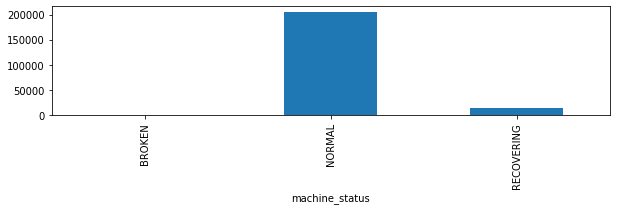

In [140]:
count.plot(kind="bar", figsize=(10, 2))
plt.show()

Видим, что целевой признак распределен неравномерно:
- Записей с состоянием помпы *'BROKEN'* крайне мало
- Записей с состоянием *'NORMAL'* подавляющее большинство
- Записей с состоянием *'RECOVERING'* всего $14477$

Поскольку **'BROKEN'** состояний не так много, можно оценить их визуально:

In [187]:
df[df.machine_status == 'BROKEN']

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,NaN,205.7292,BROKEN


Почти все поломки были в ночное время (похже 21:00).

In [4]:
s = df.isnull().sum()
s


Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


Видно, что в показаниях сенсоров имеются незаполненные ячейки. Посмотрим на них более наглядно:

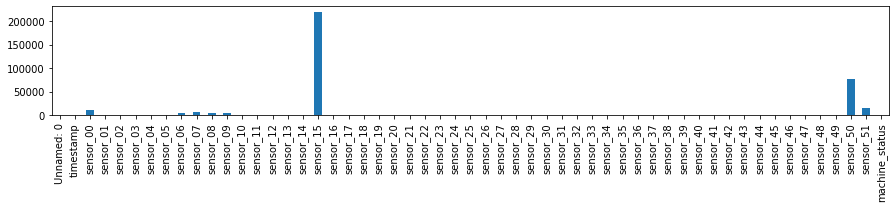

In [143]:
s.plot(kind="bar", figsize=(15, 2))
plt.show()

Показаний сенсора с номером $15$ (**sensor_15**) крайне мало -- от них придется отказаться. У остальных сенсоров не так много пропущенных значений, поэтому заполним их средним показателем.

In [5]:
df = df.fillna(value=df.mean())
df.drop(columns=["sensor_15",'Unnamed: 0', "timestamp"], inplace=True)

Посмотрим на показания датчиков:

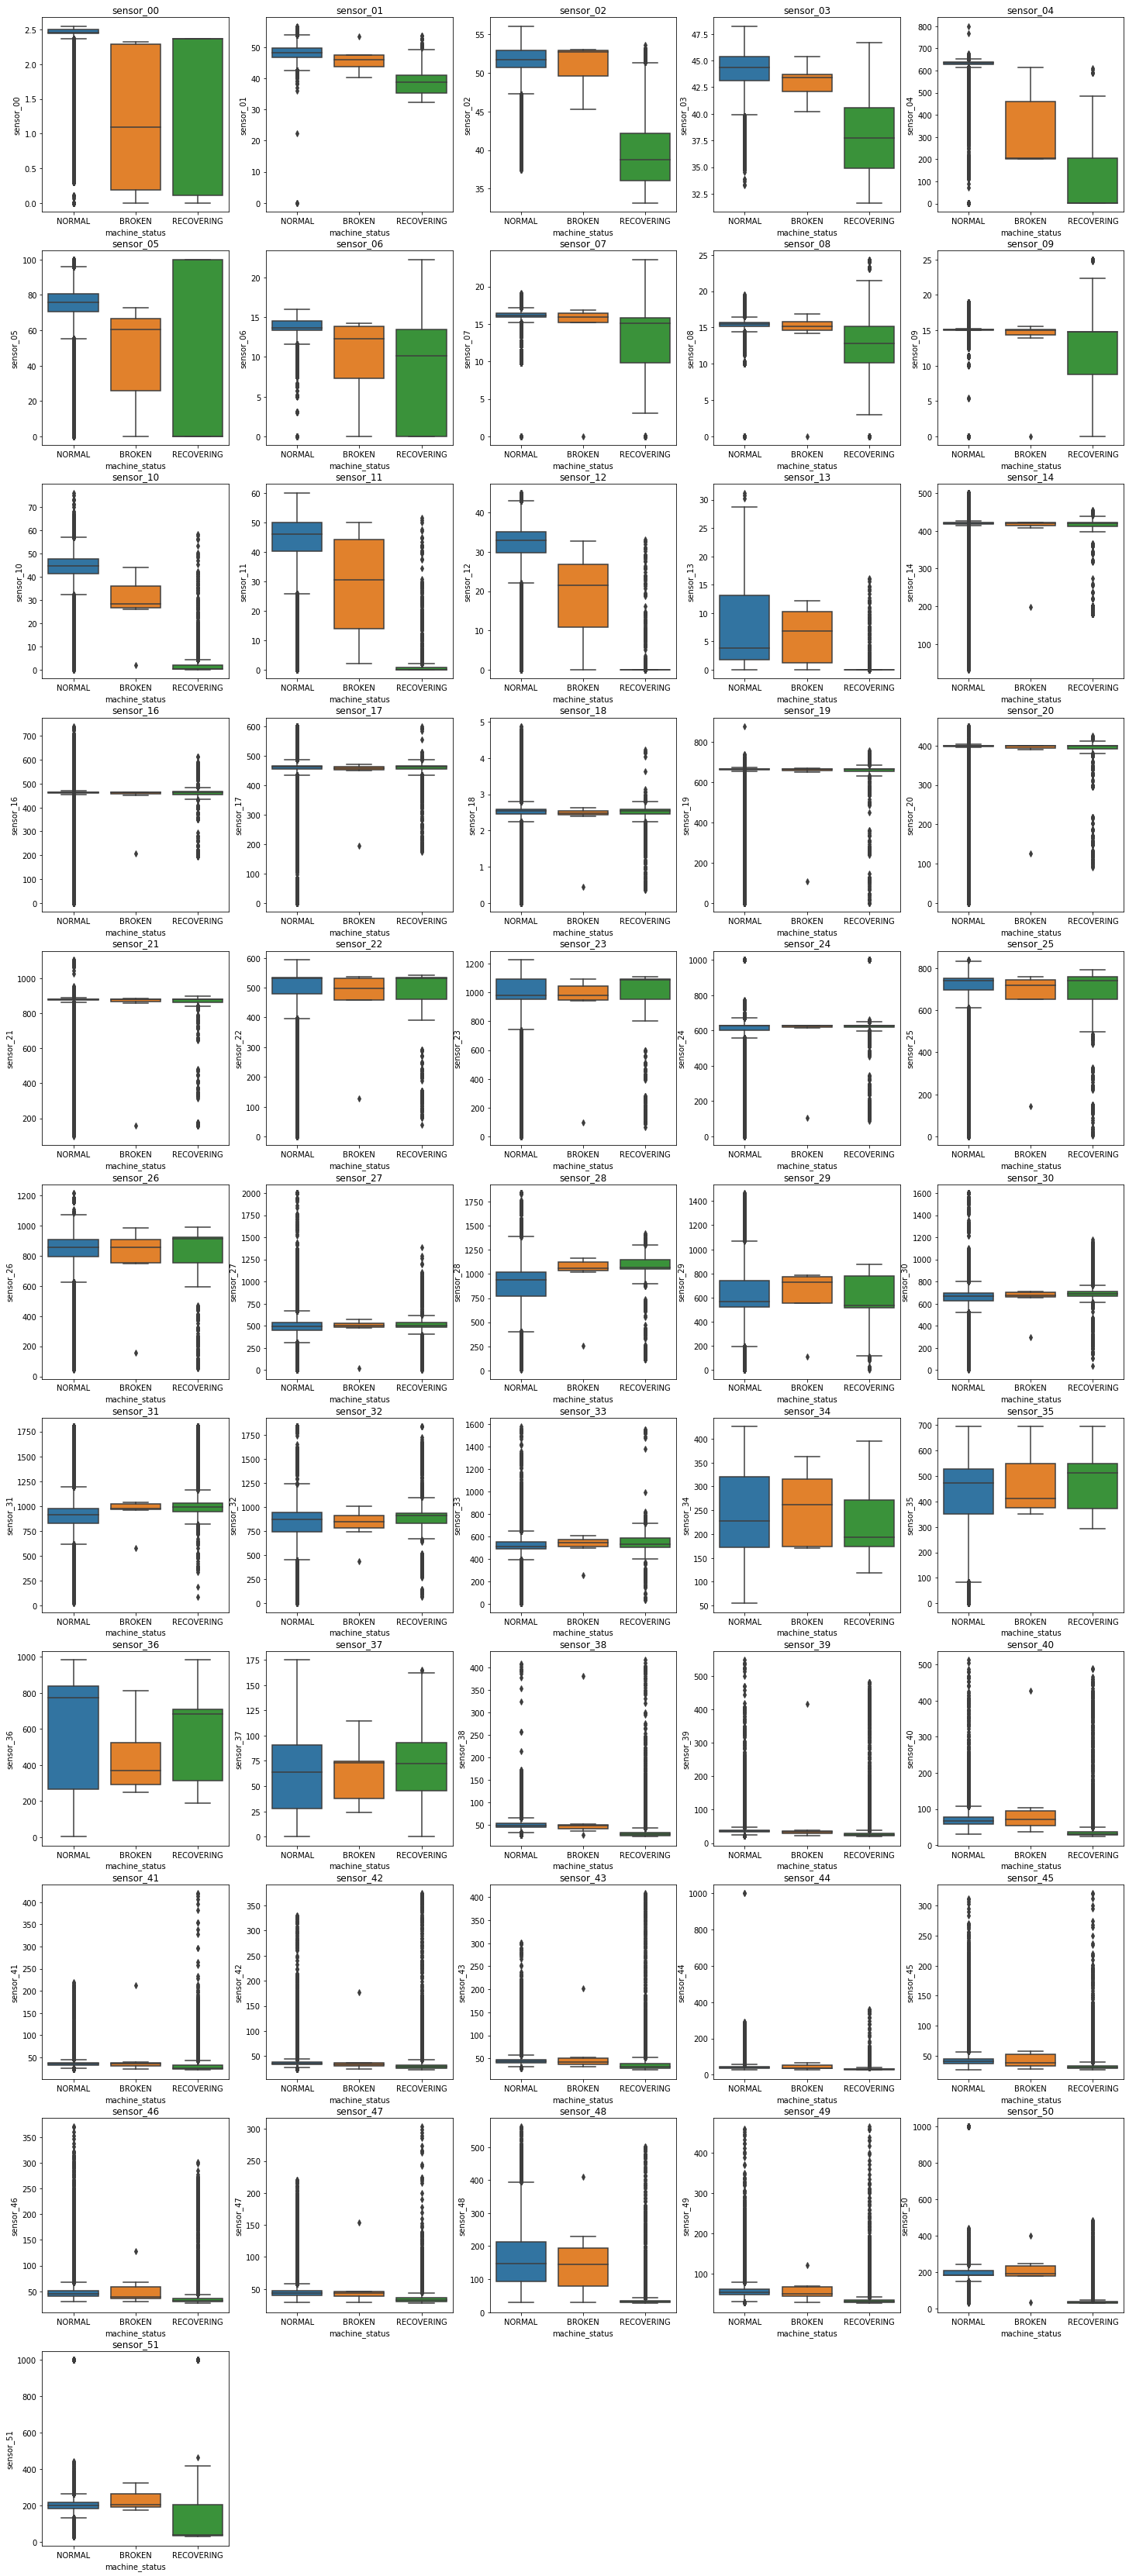

In [190]:
fig = plt.gcf()
fig.set_size_inches(25, 60)
counter = 1
for i in df.columns[0:-1]:
    tmp = plt.subplot(11, 5, counter)
    tmp.set_title(str(i))
    counter +=1
    sns.boxplot(data=df, x="machine_status", y=i)
plt.show()

Как можно увидеть в показаниях почти всех сенсоров есть выбросы, причем у некоторых довольно большое количество.

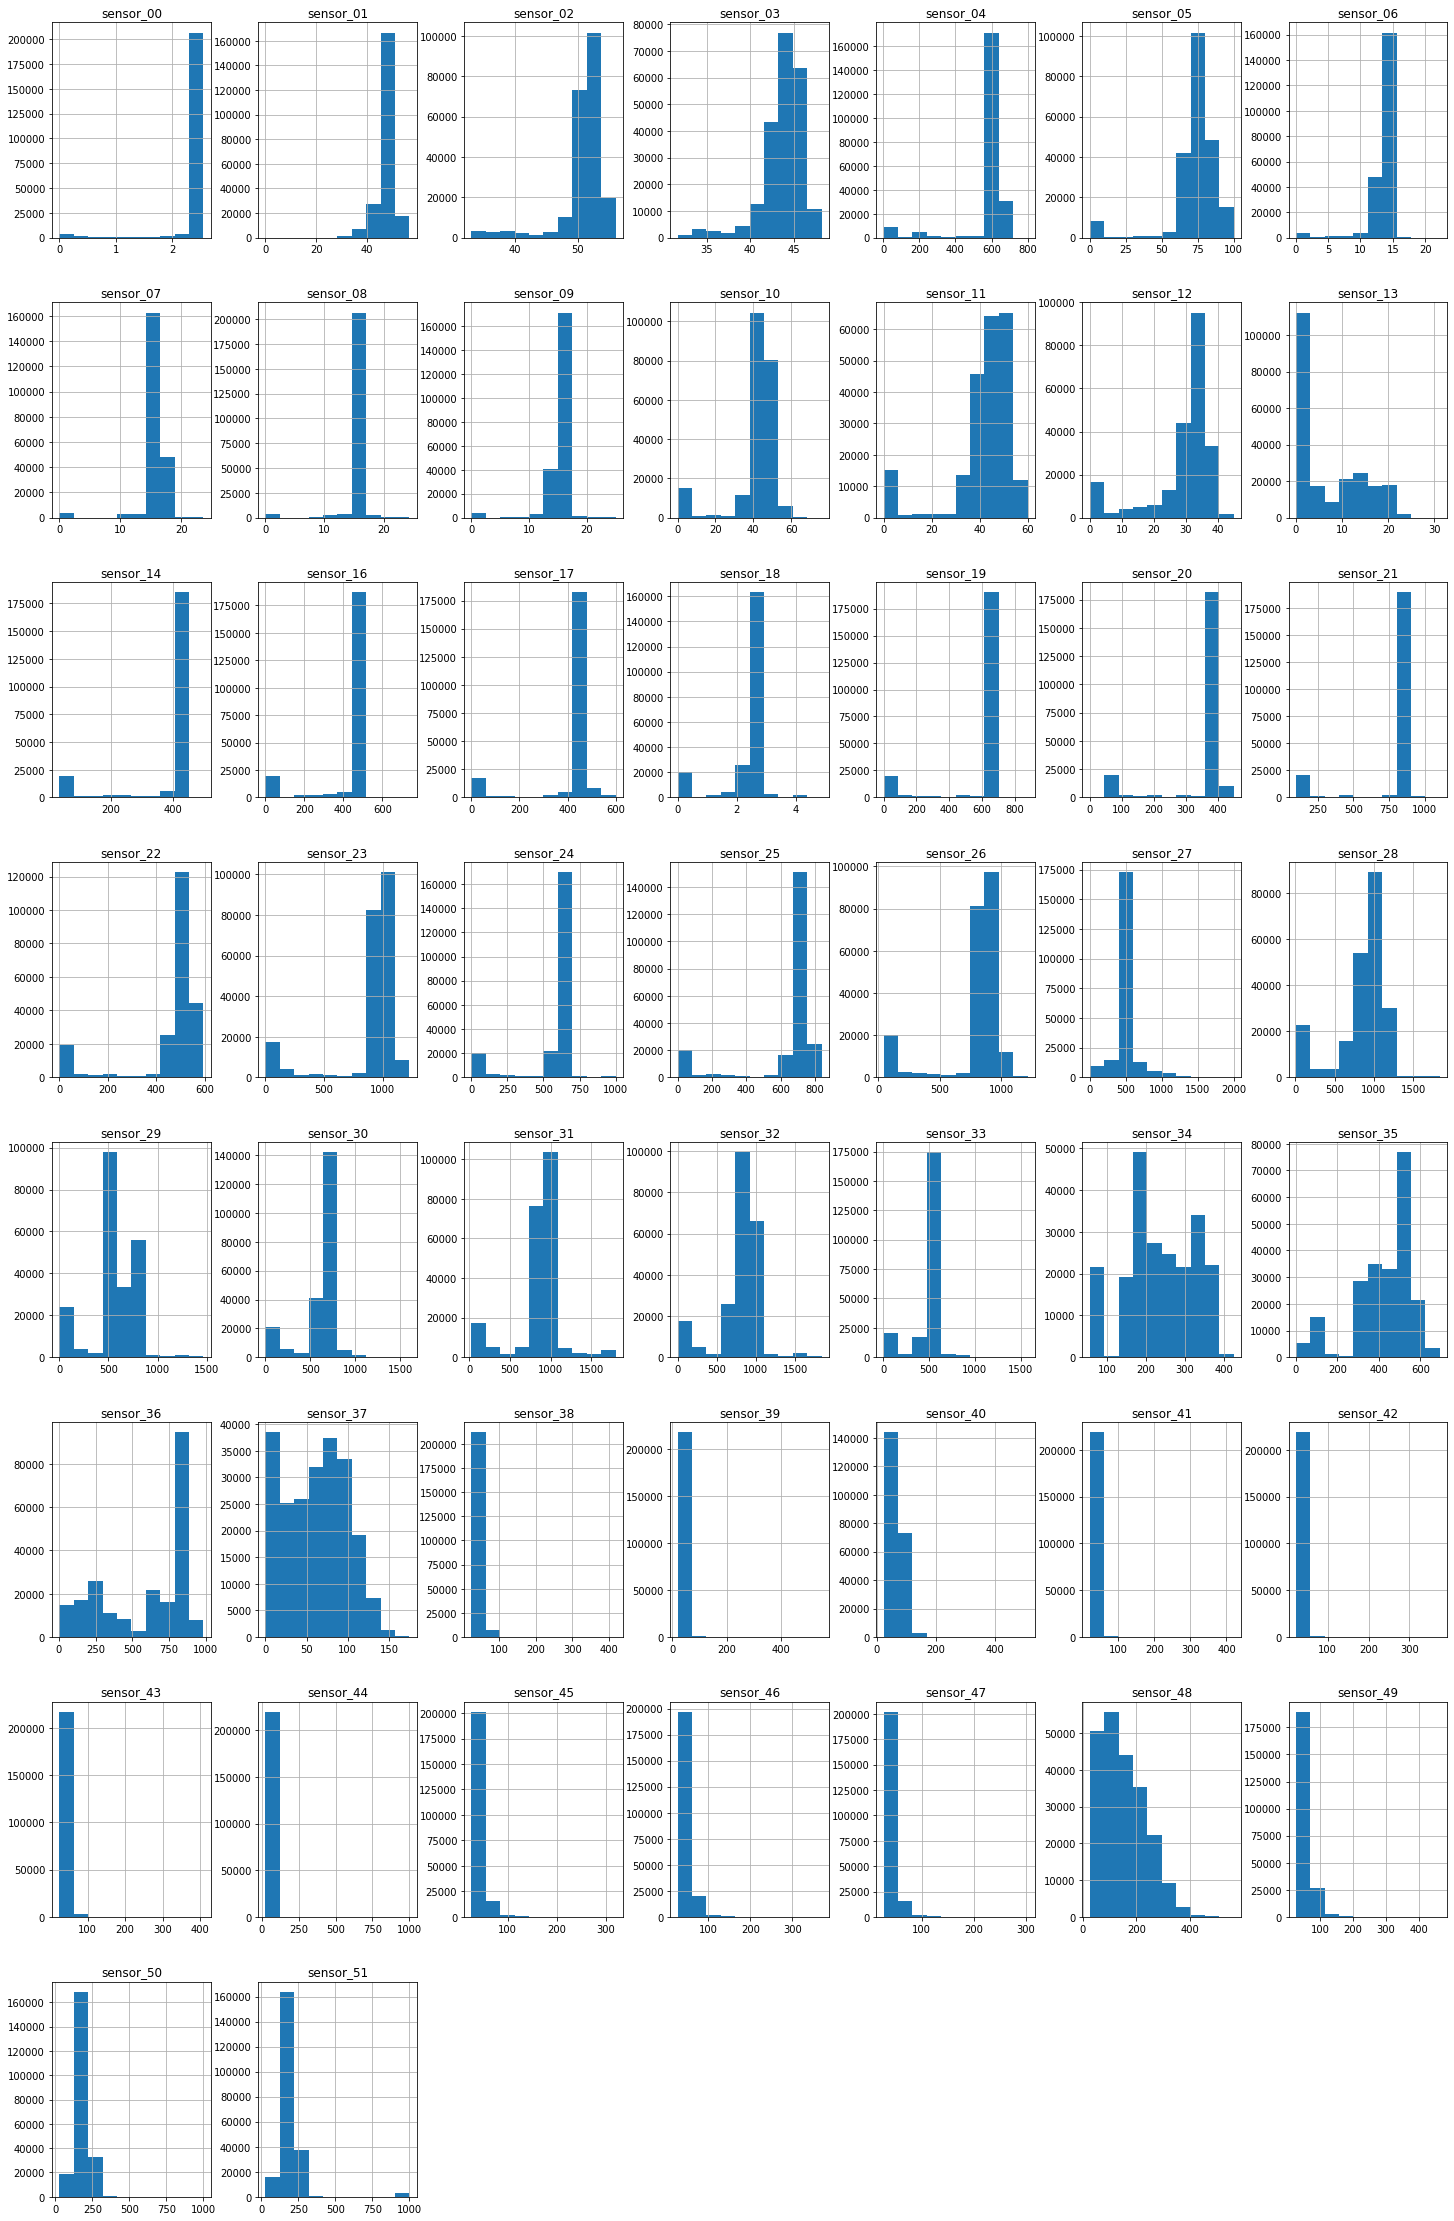

In [146]:
df.hist(figsize=(25,40))
plt.show()

Выполним очистку от выбросов:

In [6]:
sensors = df.columns
sensors = sensors[:-1]
sensors

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51'],
      dtype='object')

In [7]:
df_filtered = None
for i in sensors:
    q_low = df[i].quantile(0.1)
    q_hi  = df[i].quantile(0.9)
    df_filtered = df[(df[i] < q_hi) & (df[i] > q_low)]

In [8]:
print(df.machine_status.count() - df_filtered.machine_status.count())
df_filtered["machine_status"]
machine_statuses = df_filtered["machine_status"]
df_filtered.drop(columns='machine_status', inplace=True)

44306


$44306$ записей в датасете  было отброшено.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df_filtered)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Реализация K-means:


In [12]:
from sklearn.metrics import pairwise_distances_argmin

class MyKmeans():
    def __init__(self, n_clusters=3, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    def init_centroids(self, X):
        r = np.random.RandomState(self.random_state)
        self.centroids = X[r.choice(X.shape[0], size=self.n_clusters, replace=False)]
        #i = r.permutation(X.shape[0])[:self.n_clusters]
        #self.centroids =  X[i]
    
    def step_one(self, X):
        return pairwise_distances_argmin(X, self.centroids)
    
    def step_two(self, X, X_clustered):   
        for i in range(self.centroids.shape[0]):
            tmp = X[X_clustered == i]
            self.centroids[i] = np.mean(tmp, axis=0)
    def fit(self, X):
        self.init_centroids(X)
        iters = 0
        while iters < self.max_iter:
            clustered_X = self.step_one(X)
            old_centroids = self.centroids
            self.step_two(X, clustered_X)
            iters += 1
            #if old_centroids.all() == self.centroids.all():
                #break
                
        return self
    def fit_predict(self, X):
        return self.fit(X).predict(X)
    def predict(self, X):
        return self.step_one(X)
        
    

In [13]:
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import time

'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 176014.'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 176014.
#models = [MyKmeans(), KMeans(), AffinityPropagation(), DBSCAN()]
models = [MyKmeans(), KMeans(), DBSCAN()]
#models_name = ["MyKMeans", "KMeans", "AffinityProgation", "DBSCAN"]
models_name = ["MyKMeans", "KMeans", "DBSCAN"]
params = [{"n_clusters": ((2, 11), "int"), "max_iter": ((100, 200), "int"), "random_state":(42, "param")},
          {"random_state":(42, "param"), "n_clusters":((2, 11), "int"), "init":(["k-means++", "random"], "cat"), "n_init":((1, 20), "int"), "max_iter":((100, 300), "int"), "algorithm":(["lloyd", "elkan", "auto", "full"], "cat")}, 
          #{"damping":((0.5, 1.0), "float"), "max_iter":((100, 500), "int"), "convergence_iter":((10, 25), "int"), "affinity":(["euclidean", "precomputed"], "cat")},
          {"n_jobs":(-1, "param"), "eps":((0.2, 0.7), "float"), "min_samples":((2, 8), "int"), "algorithm":("auto", "param")}
]

def search_on_X(X, models, models_name, params, trials_num):
    results = {"Models": models_name, 
           "davies_bouldin_score": [],
           "Time": [], 
           "Best Params":[]
          }
    
    for i in range(len(models)):
        def objective(trial):
            res_param = {}
            keys = list(params[i].keys())
            for key in keys:
                tmp = None
                if (params[i][key][1] == "int"):
                    tmp = trial.suggest_int(key,params[i][key][0][0], params[i][key][0][1])
                elif (params[i][key][1] == "float"):
                    tmp = trial.suggest_float(key,params[i][key][0][0], params[i][key][0][1])
                elif (params[i][key][1] == "cat"):
                    tmp = trial.suggest_categorical(key, params[i][key][0])
                elif (params[i][key][1] == "param"):
                    tmp = params[i][key][0]
                res_param[key] = tmp

            learner = type(models[i])(**res_param)
            labels = learner.fit_predict(X)
            return davies_bouldin_score(X, labels)
        start_time = time.time()
        optuna_study = optuna.create_study(direction="minimize")
        optuna_study.optimize(objective, n_trials=trials_num)
        stop_time = time.time()
        results["Time"].append((stop_time - start_time)/trials_num)
        results["davies_bouldin_score"].append(optuna_study.best_value)
        results["Best Params"].append(optuna_study.best_params)
    return results
    
#res = search_on_X(df, models, models_name, params, n_trials)

### Снижение размерности данных с помощью PCA:
Замечание: **Affinity Propagation** не используется, т.к. для обработки датасета ему необходимо аллоцировать 210 Гб памяти, что не представляется возможможным. В качестве метрики используется **davies_bouldin_score**, т.к. вычисление **silhouette_score** занимает слишком много времени, но эта метрика будет вычислена для каждой модели после подбора гиперпараметров и уменьшения размерности данных.

In [27]:
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from math import floor, log2
sizes = [51, 25, 12, 6, 3]
res = {"MyKmeans":[], "KMeans":[], "DBSCAN":[]}
res["MyKmeans"] = []
res["KMeans"] = []
n_cluster = 3
for i in sizes:
    pca = PCA(n_components=i, random_state=42)
    df_reduced = pca.fit_transform(df)
    res["MyKmeans"].append(davies_bouldin_score(df_reduced, MyKmeans(n_clusters=n_cluster, random_state=42).fit_predict(df_reduced)))
    res["KMeans"].append(davies_bouldin_score(df_reduced, KMeans(n_clusters=n_cluster, random_state=42).fit_predict(df_reduced)))
    res["DBSCAN"].append(davies_bouldin_score(df_reduced, DBSCAN().fit_predict(df_reduced)))
    print(i, "reduced")

51 reduced
25 reduced
12 reduced
6 reduced
3 reduced


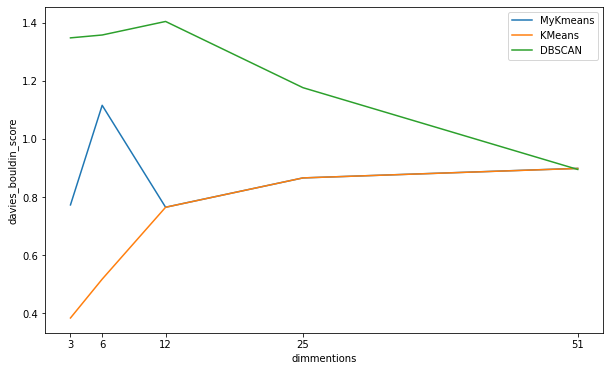

In [37]:
plt.figure(figsize=(10,6))
plt.plot(sizes, res["MyKmeans"], label="MyKmeans")
plt.plot(sizes, res["KMeans"], label="KMeans")
plt.plot(sizes, res["DBSCAN"], label="DBSCAN")
plt.xlabel('dimmentions')
plt.xticks(sizes)
plt.ylabel("davies_bouldin_score")
plt.legend()
plt.show()

В качестве метрики качества кластеризации использовалась **davies_bouldin_score** из *sklearn* (меньше = лучше). Видно, что собственная и библиотечная реализации K-Means в терминах используемой метрики положительно откликаются на уменьшение размерности данных. В то же время  **DBSCAN** показывает противоположную ситуацию: настолько сильно уменьшать размерность не стоит. Проведем дополнительное исследование **DBSCAN** с несколько меньшим уменьшением размерности данных:

In [38]:
res_ = []
sizes_ = [51, 45, 40, 35, 30]
for i in sizes_:
    pca = PCA(n_components=i, random_state=42)
    df_reduced = pca.fit_transform(df)
    res_.append(davies_bouldin_score(df_reduced, DBSCAN().fit_predict(df_reduced)))
    print(i, "reduced")

51 reduced
45 reduced
40 reduced
35 reduced
30 reduced


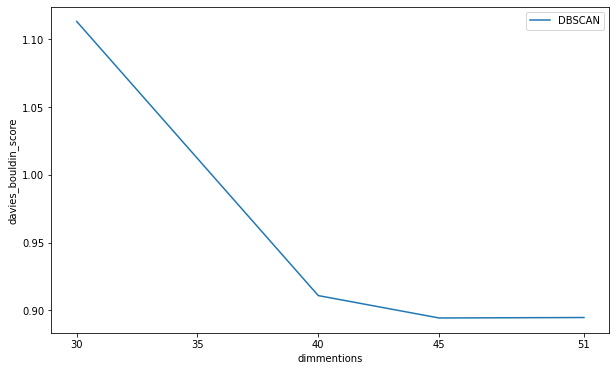

In [43]:
plt.figure(figsize=(10,6))
plt.plot(sizes_, res_, label="DBSCAN")
plt.xlabel('dimmentions')
plt.xticks(sizes_)
plt.ylabel("davies_bouldin_score")
plt.legend()
plt.show()

На данном графике видно, что практически имеет смысл уменьшить размерность данных до $40$, поскольку в таком случае это не приводит к заметному ухудшению результатов кластеризации.

В конечном результате мы имеем следующее: 
 - Для собственной реализации KMeans разумным будет уменьшение размерности данных до 12
 - Для **K-Means** из sklearn можем уменьшить размерность вплодь до 3
 - Для **DBSCAN** можешь уменьшить размерость всего до 40

### Обучение моделей:
Полагаясь на результаты эксперимента со снижением размерностей данных, обучим соответсвующие модели с подбором гиперпараметров (фреймворк Optuna) и вычислим некоторые метрики для них:
 - davies_bouldin_score
 - silhouette_score
 - calinski_harabasz_score

In [50]:
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import time


models = [MyKmeans(), KMeans(), DBSCAN()]
models_name = ["MyKMeans", "KMeans", "DBSCAN"]
models_sizes = [12, 3, 40]
params = [{"n_clusters": ((2, 7), "int"), "max_iter": ((100, 200), "int"), "random_state":(42, "param")},
          {"random_state":(42, "param"), "n_clusters":((2, 7), "int"), "init":(["k-means++", "random"], "cat"), "n_init":((1, 20), "int"), "max_iter":((100, 300), "int"), "algorithm":(["lloyd", "elkan", "auto", "full"], "cat")}, 
          {"n_jobs":(-1, "param"), "eps":((0.2, 0.7), "float"), "min_samples":((2, 8), "int"), "algorithm":("auto", "param")}
]

def search_on_X(X, models, models_name, sizes,  params, trials_num):
    results = {"Models": models_name, 
           "davies_bouldin_score": [],
           "Time": [], 
           "Best Params":[]
          }
    
    for i in range(len(models)):
        def objective(trial):
            res_param = {}
            keys = list(params[i].keys())
            for key in keys:
                tmp = None
                if (params[i][key][1] == "int"):
                    tmp = trial.suggest_int(key,params[i][key][0][0], params[i][key][0][1])
                elif (params[i][key][1] == "float"):
                    tmp = trial.suggest_float(key,params[i][key][0][0], params[i][key][0][1])
                elif (params[i][key][1] == "cat"):
                    tmp = trial.suggest_categorical(key, params[i][key][0])
                elif (params[i][key][1] == "param"):
                    tmp = params[i][key][0]
                res_param[key] = tmp
            
            pca = PCA(n_components = sizes[i], random_state=42)
            X_reduced = pca.fit_transform(X)
            
            learner = type(models[i])(**res_param)
            labels = learner.fit_predict(X_reduced)
            return davies_bouldin_score(X_reduced, labels)
        start_time = time.time()
        optuna_study = optuna.create_study(direction="minimize")
        optuna_study.optimize(objective, n_trials=trials_num)
        stop_time = time.time()
        results["Time"].append((stop_time - start_time)/trials_num)
        results["davies_bouldin_score"].append(optuna_study.best_value)
        results["Best Params"].append(optuna_study.best_params)
    return results

Запустим подбор гиперпараметров:

In [51]:
search_results = search_on_X(df, models, models_name, models_sizes, params, trials_num = 30)

Досчитаем метрики:

In [56]:
search_results["silhouette_score"] = []
search_results["calinski_harabasz_score"] = []

for i in range(len(models)):
    params = search_results["Best Params"][i]
    df_reduced = PCA(n_components=models_sizes[i], random_state=42).fit_transform(df)
    labels = type(models[i])(**params).fit_predict(df_reduced)
    search_results["silhouette_score"].append(silhouette_score(df_reduced, labels))
    search_results["calinski_harabasz_score"].append(calinski_harabasz_score(df_reduced, labels))
    print(i, "done")
               

0 done
1 done
2 done


Посмотрим на результат:

In [80]:
metrics_results = pd.DataFrame(data = search_results).drop(columns = ["Best Params"], inplace=False)
metrics_results[["Models", "davies_bouldin_score", "silhouette_score", "calinski_harabasz_score", "Time"]]

,Models,davies_bouldin_score,silhouette_score,calinski_harabasz_score,Time
0,MyKMeans,0.764703,0.585301,94257.648405,2.465031
1,KMeans,0.383395,0.730643,233521.245678,0.504599
2,DBSCAN,0.676713,-0.432226,63.466563,13.527971


У **DBSCAN** аномально плохие результаты метрик **silhouette_score** и **calinski_harabasz_score**. Посмотрим на результаты кластеризации:


In [81]:
DBSCAN_params = search_results["Best Params"][-1]
DBSCAN_labels = DBSCAN(**DBSCAN_params).fit_predict(df)

In [120]:
print(f"Всего кластеров:{np.unique(DBSCAN_labels).shape[0]}")
print(f"Кластеризированно объектов: {DBSCAN_labels[DBSCAN_labels != -1].shape[0]}")
print(f"Не кластеризированно объектов: {DBSCAN_labels[DBSCAN_labels == -1].shape[0]}")


Всего кластеров:181
Кластеризированно объектов: 1765
Не кластеризированно объектов: 174249


Можно увидеть, что DBSCAN удалось кластеризировать не так много объектов из датасета, более того, эти объекты распределены по 180 кластерам (кластер "-1" -- это в терминах DBSCAN неудачи). 

Для сравнения обучим **DBSCAN** со стандартными параметрами и на всех признаках датасета:

In [121]:
DBSCAN_labels_default = DBSCAN().fit_predict(df)
print(f"silhouette_score: {silhouette_score(df,  DBSCAN_labels_default)}")
print(f"Всего кластеров:{np.unique(DBSCAN_labels_default).shape[0]}")
print(f"Кластеризированно объектов: {DBSCAN_labels_default[DBSCAN_labels_default != -1].shape[0]}")
print(f"Не кластеризированно объектов: {DBSCAN_labels_default[DBSCAN_labels_default == -1].shape[0]}")

silhouette_score: -0.5531418520856034
Всего кластеров:744
Кластеризированно объектов: 6676
Не кластеризированно объектов: 169338


DBSCAN со стандартными параметрами отрабатывает еще хуже в терминах метрики **silhouette_score**, хотя объектов, помеченных как шум, стало меньше. Кластеров стало еще больше. Можно сделать вывод, что **DBSCAN** не очень хорошо справляется с задачей кластеризации этого датасета.

Вернемся к остальным результатам:
 - собственная реализация K-Means отрабатывает значительно хуже библиотечной. При этом ей требуется почти в 5 раз больше времени.
 - K-Means из scklearn явный фаворит
 - DBSCAN, как уже было упомянуто ранее, совсем плох и требует много времени (в 25 раз больше чем K-Means)
 
 
Оптимальным числом кластеров для обеих реализаций K-Means является 3 кластера (ровно столько же классов в оригинальном датасете: NORMAL, RECOVERING и  BROKEN) 


In [127]:
print("Кластеров в MyKmeans: ", search_results["Best Params"][0]["n_clusters"])
print("Кластеров в KMeans: ", search_results["Best Params"][1]["n_clusters"])

Кластеров в MyKmeans:  3
Кластеров в KMeans:  3


### Визуализация данных

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(random_state=42, n_components=2)
df_pca = pca.fit_transform(df)
tsne = TSNE(random_state=42, n_components=2)
df_tsne = tsne.fit_transform(df)

In [16]:
machine_statuses = machine_statuses.apply(lambda x: 0 if x == "NORMAL" else 1 if x == "RECOVERING" else 2)

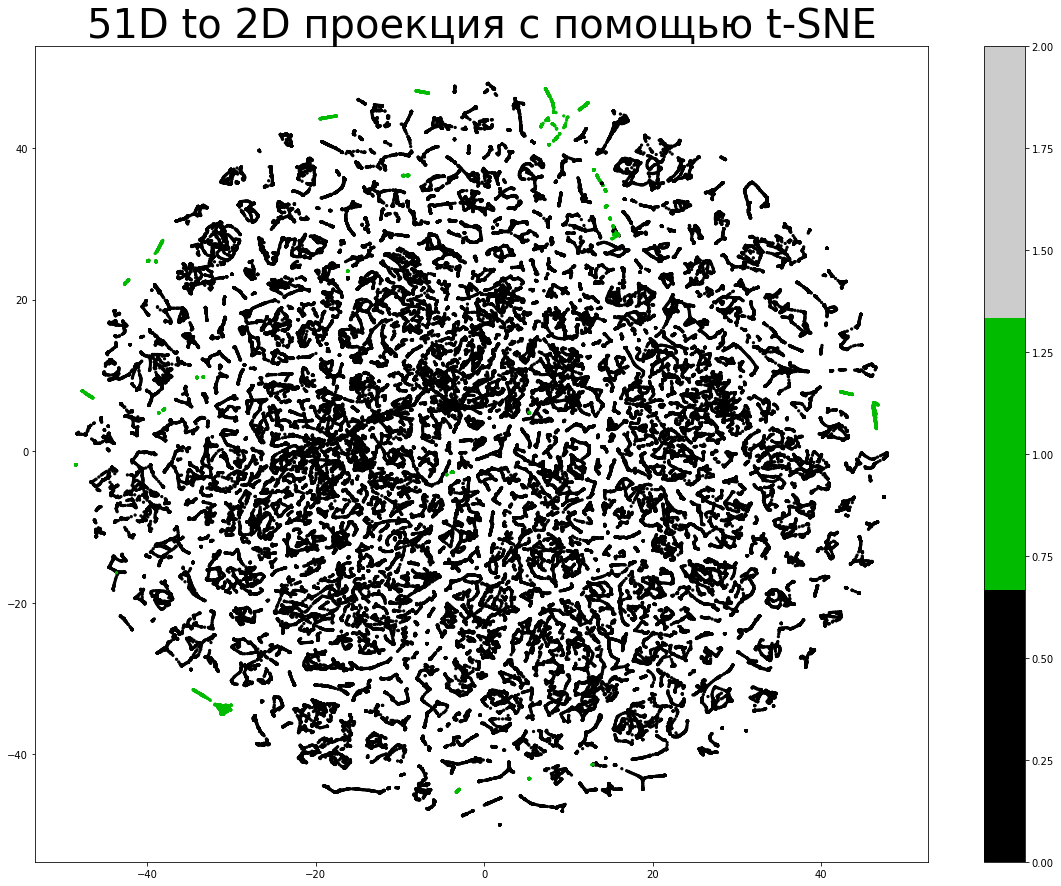

In [205]:
plt.figure(figsize=(20, 15))
plt.scatter(
    df_tsne[:, 0],
    df_tsne[:, 1],
    c=machine_statuses,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()
plt.title("51D to 2D проекция с помощью t-SNE", fontsize=40)
plt.show()

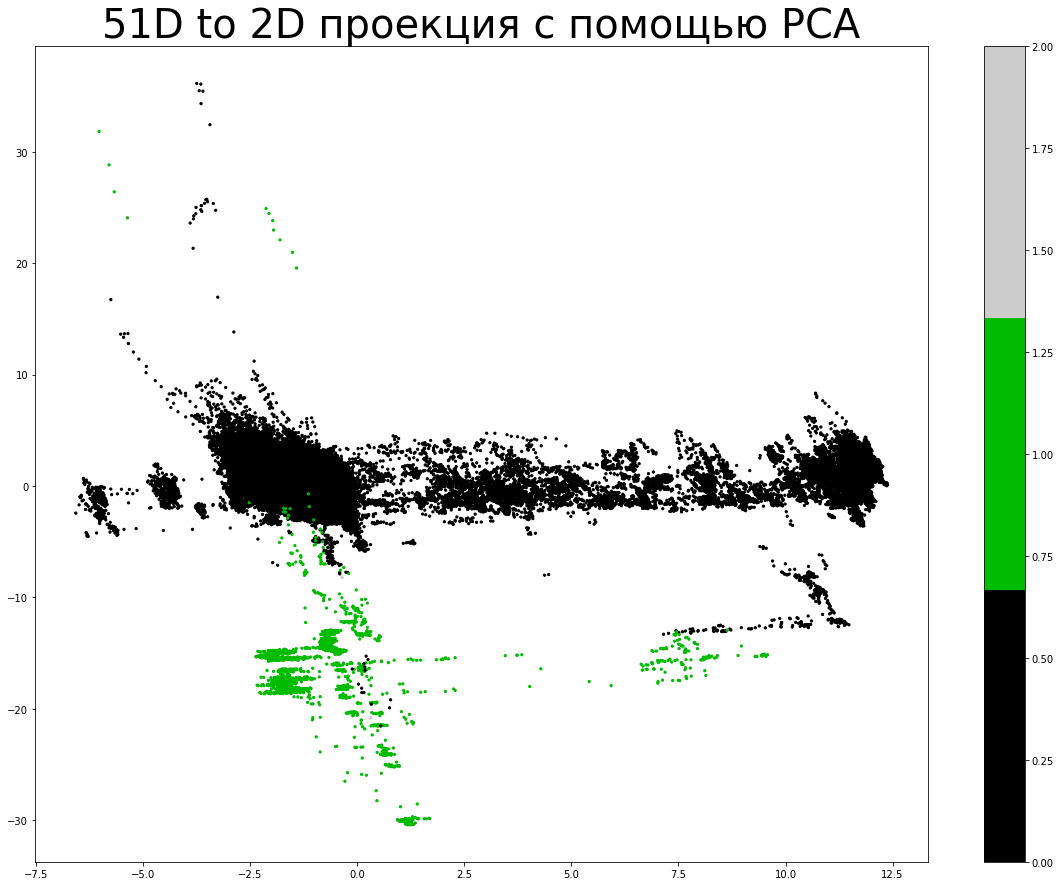

In [204]:
plt.figure(figsize=(20, 15))
plt.scatter(
    df_pca[:, 0],
    df_pca[:, 1],
    c=machine_statuses,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()
plt.title("51D to 2D проекция с помощью PCA", fontsize=40)
plt.show()

#### Визуализация результатов кластеризации:

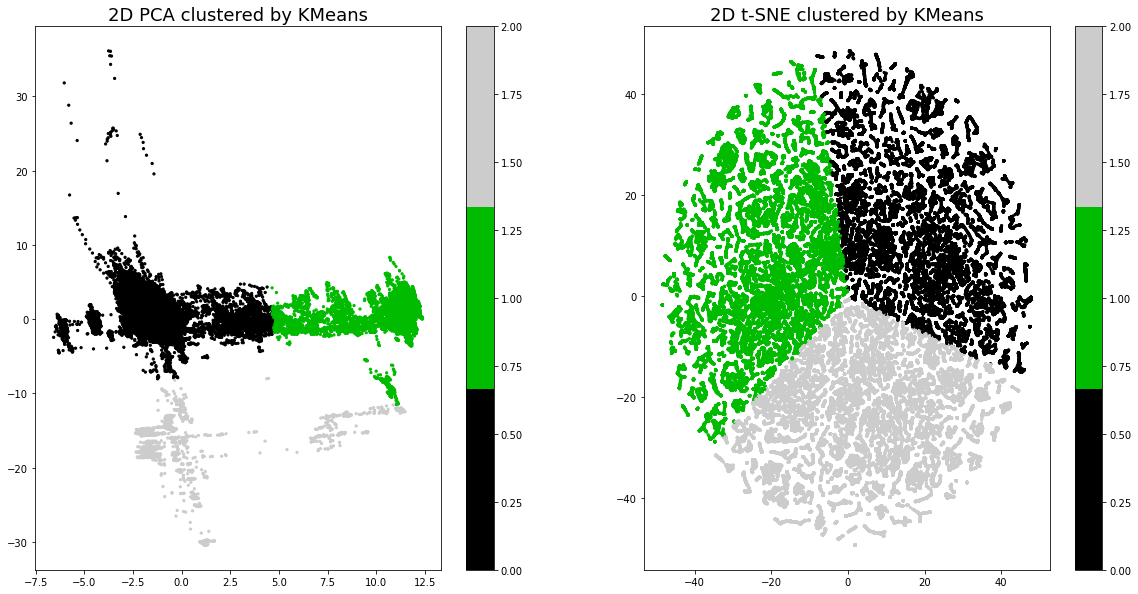

In [17]:
kmeans_pca_labels = KMeans(n_clusters=3, random_state=42).fit_predict(df_pca)
kmeans_tsne_labels = KMeans(n_clusters=3, random_state=42).fit_predict(df_tsne)
plt.figure(figsize=(20, 10))
tmp = plt.subplot(1, 2, 1)
tmp.set_title("2D PCA clustered by KMeans", fontsize=18)
plt.scatter(
    df_pca[:, 0],
    df_pca[:, 1],
    c=kmeans_pca_labels,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()

tmp = plt.subplot(1, 2, 2)
tmp.set_title("2D t-SNE clustered by KMeans", fontsize=18)
plt.scatter(
    df_tsne[:, 0],
    df_tsne[:, 1],
    c=kmeans_tsne_labels,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()
              
plt.show()

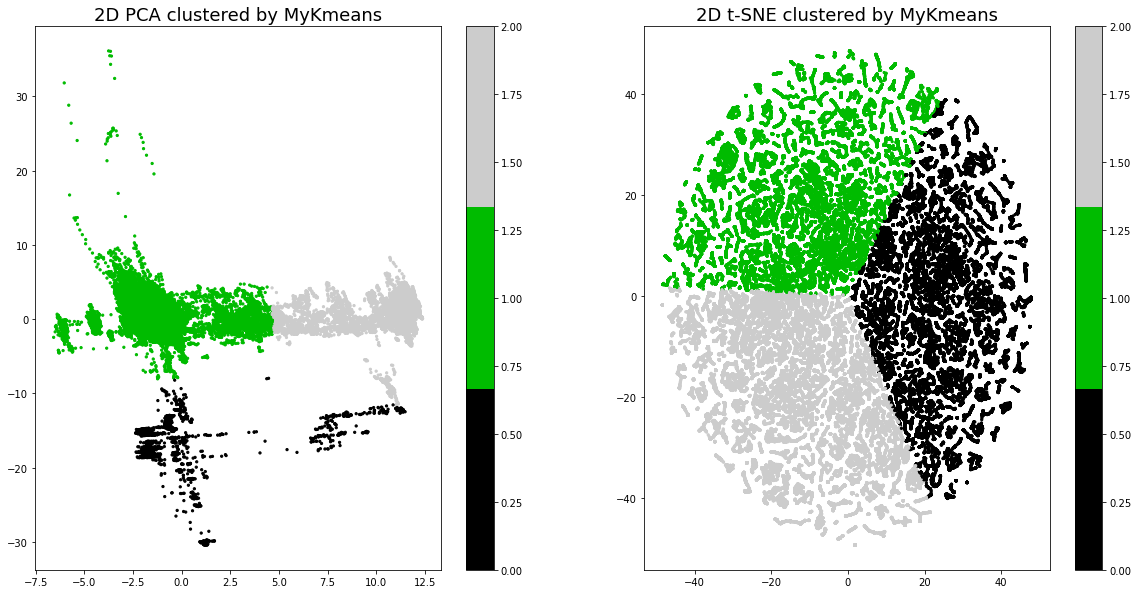

In [20]:
mykmeans_pca_labels = MyKmeans(n_clusters=3, random_state=42).fit_predict(df_pca)
mykmeans_tsne_labels = MyKmeans(n_clusters=3, random_state=42).fit_predict(df_tsne)
plt.figure(figsize=(20, 10))
tmp = plt.subplot(1, 2, 1)
tmp.set_title("2D PCA clustered by MyKmeans", fontsize=18)
plt.scatter(
    df_pca[:, 0],
    df_pca[:, 1],
    c=mykmeans_pca_labels,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()

tmp = plt.subplot(1, 2, 2)
tmp.set_title("2D t-SNE clustered by MyKmeans", fontsize=18)
plt.scatter(
    df_tsne[:, 0],
    df_tsne[:, 1],
    c=mykmeans_tsne_labels,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()
              
plt.show()

In [ ]:
DBSCAN_pca_labels = DBSCAN().fit_predict(df_pca)
DBSCAN_tsne_labels = DBSCAN().fit_predict(df_tsne)
plt.figure(figsize=(20, 10))
tmp = plt.subplot(1, 2, 1)
tmp.set_title("2D PCA clustered by DBSCAN", fontsize=18)
plt.scatter(
    df_pca[:, 0],
    df_pca[:, 1],
    c=DBSCAN_pca_labels,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()

tmp = plt.subplot(1, 2, 2)
tmp.set_title("2D t-SNE clustered by DBSCAN", fontsize=18)
plt.scatter(
    df_tsne[:, 0],
    df_tsne[:, 1],
    c=DBSCAN_tsne_labels,
    #alpha=0.7,
    s=5,
    cmap=plt.cm.get_cmap("nipy_spectral", 3),
)
plt.colorbar()
              
plt.show()

В этом случае графиков не будет, поскольку **DBSCAN** начинает агрессивно аллоцировать оперативную память, что приводит ядро ноутбука к экстренному завершению (16 Гб ОЗУ не хватает)